In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import sys
sys.path.append('/content/drive/My Drive/module/ngodingpython/')
from helpers import load_image_directory, plot_graph

In [0]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os
import pickle

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

In [0]:
# Definisikan path dataset dan tempat menyimpan model
BASE = '/content/drive/My Drive/'
dataset = BASE + '/data/dataset_motogp/'
model_path = BASE + 'model_baru_rima.pkl' # tempat menyimpan model
labelbin = BASE + 'model_asik1.pkl'

In [0]:
#  hyperparameter
EPOCHS = 200
INIT_LR = 0.001
BS = 64
IMAGE_DIMS = (96,96,3) # 3 items (W, H, D)

In [0]:
# inisialisasi list data dan label
data, labels = load_image_directory(dataset, IMAGE_DIMS)

In [0]:
unique_label = list(set(labels))
print(unique_label)

['rossi', 'vinales', 'lorenzo', 'marquez', 'dovizioso', 'pedrosa']


In [0]:
# Normalisasi data
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matriks: {:2f}MB".format(
    data.nbytes/ (1024 * 1000.0)))

[INFO] data matriks: 98.064000MB


## Ekstraksi Fitur by RestNet

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

In [0]:
resnet50_model=ResNet50(weights = 'imagenet', include_top=False, pooling='avg')

In [0]:
#preprocess input data doang
data_preprocess=preprocess_input(np.array(data))

In [0]:
#bottleneck feature : metode input data dengan konsep spt bottleneck
bottleneck_features=resnet50_model.predict(data_preprocess)

In [0]:
bottleneck_features[0].shape 

(2048,)

## MODELING

In [0]:
labels

array(['vinales', 'rossi', 'marquez', 'rossi', 'marquez', 'marquez',
       'pedrosa', 'marquez', 'lorenzo', 'pedrosa', 'dovizioso', 'rossi',
       'marquez', 'marquez', 'marquez', 'lorenzo', 'dovizioso', 'pedrosa',
       'pedrosa', 'marquez', 'vinales', 'pedrosa', 'marquez', 'lorenzo',
       'pedrosa', 'marquez', 'marquez', 'dovizioso', 'vinales', 'lorenzo',
       'marquez', 'lorenzo', 'dovizioso', 'dovizioso', 'rossi',
       'dovizioso', 'rossi', 'marquez', 'vinales', 'pedrosa', 'rossi',
       'marquez', 'lorenzo', 'dovizioso', 'lorenzo', 'dovizioso', 'rossi',
       'vinales', 'dovizioso', 'vinales', 'vinales', 'lorenzo', 'rossi',
       'rossi', 'marquez', 'marquez', 'lorenzo', 'pedrosa', 'dovizioso',
       'dovizioso', 'dovizioso', 'vinales', 'marquez', 'lorenzo',
       'dovizioso', 'pedrosa', 'lorenzo', 'lorenzo', 'lorenzo', 'pedrosa',
       'vinales', 'lorenzo', 'rossi', 'lorenzo', 'lorenzo', 'vinales',
       'dovizioso', 'rossi', 'pedrosa', 'rossi', 'pedrosa', 'marque

In [0]:
df=pd.DataFrame(bottleneck_features)
df['labels']=labels
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,labels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095964,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.189180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,vinales
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090047,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rossi
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082169,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.236159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,marquez
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003325,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.197403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rossi
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034760,0.0096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.274117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,marquez


In [0]:
#PCA : untuk reduksi dimensi agar dapat divisualisasi
from sklearn.decomposition import PCA

pca= PCA(n_components=2)
pca.fit(bottleneck_features)
hasil_pca=pca.transform(bottleneck_features)

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

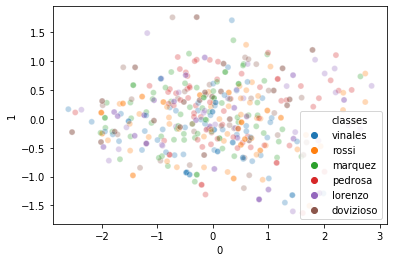

In [0]:
df_hasil_pca=pd.DataFrame(hasil_pca)
df_hasil_pca['classes']=labels
sns.scatterplot(x=0, y=1, data=df_hasil_pca, hue='classes', alpha=0.3)

## CNN

In [0]:
# binarisasi label
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [0]:
labels[:1].argmax()
lb.classes_[:]

array(['dovizioso', 'lorenzo', 'marquez', 'pedrosa', 'rossi', 'vinales'],
      dtype='<U9')

In [0]:
# train-test-split
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

In [0]:
# konstruksi ImageGenerator
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [0]:
class MyModel:
	@staticmethod
	def build(width, height, depth, classes):
		# inisialisasi model dengan konfigurasi
		# "channel last"
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# make sure channel first tetap jalan
		if K.image_data_format() == 'channel_first':
			inputShape = (depth, height, width)
			chanDim = 1

		model.add(tf.keras.layers.Conv2D(32, kernel_size=(5,5), input_shape=inputShape, padding='same', activation='relu'))
		model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
		model.add(tf.keras.layers.Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'))
		model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
		model.add(tf.keras.layers.Flatten())
		model.add(tf.keras.layers.Dense(1024, activation='relu'))
		model.add(tf.keras.layers.Dropout(0.2))
		model.add(tf.keras.layers.Dense(6, activation='softmax'))

		return model

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              37749760  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

In [0]:
# inisialisasi model
print("[INFO] Mengcompile Jaringan")
model = MyModel.build(width=IMAGE_DIMS[1], 
    height=IMAGE_DIMS[0], depth=IMAGE_DIMS[2], 
    classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] Mengcompile Jaringan


In [0]:
# latih jaringan
print("[INFO] Melatih Jaringan")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

[INFO] Melatih Jaringan
Epoch 1/200
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 4s 785ms/step - loss: 0.6354 - acc: 0.7906 - val_loss: 0.4483 - val_acc: 0.8333
Epoch 2/200
5/5 [==============================] - 1s 187ms/step - loss: 0.4488 - acc: 0.8333 - val_loss: 0.4419 - val_acc: 0.8333
Epoch 3/200
5/5 [==============================] - 1s 176ms/step - loss: 0.4491 - acc: 0.8333 - val_loss: 0.4441 - val_acc: 0.8333
Epoch 4/200
5/5 [==============================] - 1s 190ms/step - loss: 0.4391 - acc: 0.8333 - val_loss: 0.4234 - val_acc: 0.8333
Epoch 5/200
5/5 [==============================] - 1s 182ms/step - loss: 0.4303 - acc: 0.8333 - val_loss: 0.4130 - val_acc: 0.8333
Epoch 6/200
5/5 [==============================] - 1s 175ms/step - loss: 0.4078 - acc: 0.8333 - val_loss: 0.3883 - val_acc: 0.8333
Epoch 7/200
5/5 [==============================] - 1s 198ms/step - loss: 0.3910 - acc: 0.8333 - 

In [0]:
print("Nilai Overal Acc: ", np.mean(H.history['acc']))
print("Nilai Loss      : ", np.mean(H.history['loss']))
print("Nilai Val Loss  : ", np.mean(H.history['val_loss']))
print("Nilai Val Acc   : ", np.mean(H.history['val_acc']))

Nilai Overal Acc:  0.94227415
Nilai Loss      :  0.13354599479519705
Nilai Val Loss  :  0.30875769022852184
Nilai Val Acc   :  0.88658434


In [0]:
# menyimpan model
print("[INFO] Menyimpan Model Kedalam Disk")
model.save(model_path)

[INFO] Menyimpan Model Kedalam Disk


In [0]:
print("[INFO] Menyimpan Label Binary")
f = open(labelbin, 'wb')
f.write(pickle.dumps(lb))
f.close()

[INFO] Menyimpan Label Binary


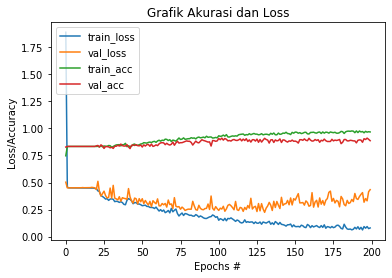

In [0]:
# plot akurasi
plot_graph(H, EPOCHS)

In [0]:
# Load Gambar 1
import matplotlib.image as mpimg
image_test = '/content/drive/My Drive/dataset_clean/rosi.jpg'
image_show = mpimg.imread(image_test)
image = load_img(image_test, target_size=(96, 96))

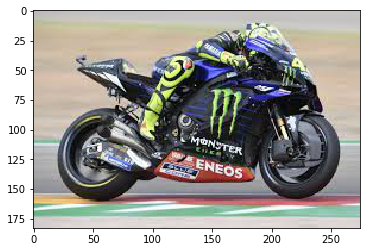

In [0]:
plt.imshow(image_show)

In [0]:
# pra proses
image = np.array(image, dtype="float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [0]:
# klasifikasi input
print('[INFO] Kelas Gambar + Confidence Score')
proba = model.predict(image)[0]
kelas = lb.classes_[:]
# idx = np.argmax(proba)
counter = 0
for kel in kelas:
  print(kel)
  
  # print((proba[counter]*100),'%')
  print("{:.2f}%".format(proba[counter] * 100))
  counter += 1  
    

[INFO] Kelas Gambar + Confidence Score
dovizioso
0.00%
lorenzo
0.00%
marquez
0.00%
pedrosa
0.00%
rossi
100.00%
vinales
0.00%


In [0]:
# Load Gambar 2
import matplotlib.image as mpimg
image_test = '/content/drive/My Drive/dataset_clean/vinales/00000220.jpg'
image_show = mpimg.imread(image_test)
image = load_img(image_test, target_size=(96, 96))

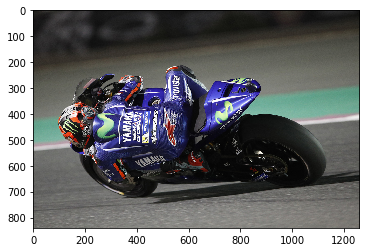

In [0]:
plt.imshow(image_show)

In [0]:
# pra proses
image = np.array(image, dtype="float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [0]:
# klasifikasi input
print('[INFO] Kelas Gambar + Confidence Score')
proba = model.predict(image)[0]
kelas = lb.classes_[:]
# idx = np.argmax(proba)
counter = 0
for kel in kelas:
  print(kel)
  
  # print((proba[counter]*100),'%')
  print("{:.2f}%".format(proba[counter] * 100))
  counter += 1  

[INFO] Kelas Gambar + Confidence Score
dovizioso
0.00%
lorenzo
0.00%
marquez
0.00%
pedrosa
0.00%
rossi
16.85%
vinales
83.15%


In [0]:
# Load Gambar 3
import matplotlib.image as mpimg
image_test = '/content/drive/My Drive/dataset_clean/rosi vs marq.jpg'
image_show = mpimg.imread(image_test)
image = load_img(image_test, target_size=(96, 96))

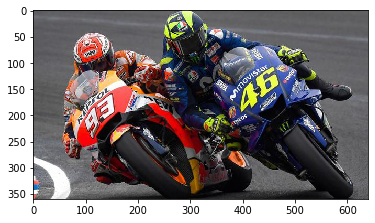

In [0]:
plt.imshow(image_show)

In [0]:
# pra proses
image = np.array(image, dtype="float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [0]:
# klasifikasi input
print('[INFO] Kelas Gambar + Confidence Score')
proba = model.predict(image)[0]
kelas = lb.classes_[:]
# idx = np.argmax(proba)
counter = 0
for kel in kelas:
  print(kel)
  
  # print((proba[counter]*100),'%')
  print("{:.2f}%".format(proba[counter] * 100))
  counter += 1  

[INFO] Kelas Gambar + Confidence Score
dovizioso
0.00%
lorenzo
0.00%
marquez
0.00%
pedrosa
0.00%
rossi
99.99%
vinales
0.01%
